In [1]:
from scipy.spatial import distance
import numpy as np
from pyvis.network import Network
import networkx as nx
from IPython.display import HTML
from itertools import combinations

### functions

In [94]:
def get_Pc(P,x):
    Pc=np.zeros((len(P)-x+1,))
    Pc[0]=np.sum(P[:x])
    Pc[1:]=P[x:]
    return Pc

def calc_CDD(P,Q):
    CDD=0
    for x in range(len(P)-1):
        CDD+=distance.jensenshannon(get_Pc(P,x+1), get_Pc(Q,x+1),base=2.0)
    return CDD

def calc_Dw(path):
    dw=0
    for i in range(len(path)-1):
        dw+=Dw2[(path[i],path[i+1])]
    return dw

### Define network
* nodes
* links between nodes
* weights of those links

In [88]:
nodes=np.arange(1,5)
edge_list=[(1,2),(1,3),(2,3),(3,4)]
weights_array=np.array([0.5,1,2,2])

In [89]:
Dw_array=weights_array**(-1)

In [90]:
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

In [91]:
weights={}
Dw={}

for i in range(len(list(G.edges))):
    weights[list(G.edges)[i]]=weights_array[i]
    Dw[list(G.edges)[i]]=Dw_array[i]
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = Dw, name = 'Dw')
G.edges(data = True)

EdgeDataView([(1, 2, {'weight': 0.5, 'Dw': 2.0}), (1, 3, {'weight': 1.0, 'Dw': 1.0}), (2, 3, {'weight': 2.0, 'Dw': 0.5}), (3, 4, {'weight': 2.0, 'Dw': 0.5})])

In [92]:
Dw2=Dw.copy()
for key in Dw.keys():
    Dw2[(key[1],key[0])]=Dw[(key)]

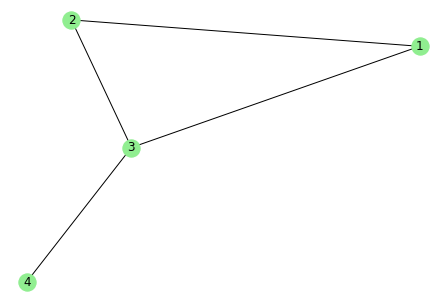

In [93]:
nx.draw(G, with_labels=True, node_color='lightgreen')

### Calculate shortest geodesical and weighted paths for every combination of nodes

In [52]:
spaths={}
for n_comb in combinations(nodes, 2):
    spaths[n_comb]={}
    spaths[n_comb]['min_steps']=list(nx.all_shortest_paths(G, source=n_comb[0], target=n_comb[1]))[0]
    spaths[n_comb]['Dg']=len(spaths[n_comb]['min_steps'])-1
    spaths[n_comb]['min_weight']=list(nx.all_shortest_paths(G, source=n_comb[0], target=n_comb[1],
                                                            weight='Dw'))[0]
    spaths[n_comb]['Dw']=calc_Dw(spaths[n_comb]['min_weight'])
    spaths[n_comb]['delta']=spaths[n_comb]['Dw']/spaths[n_comb]['Dg']

In [53]:
for key in spaths.keys():
    print(key,spaths[key])

(1, 2) {'min_steps': [1, 2], 'Dg': 1, 'min_weight': [1, 3, 2], 'Dw': 1.5, 'delta': 1.5}
(1, 3) {'min_steps': [1, 3], 'Dg': 1, 'min_weight': [1, 3], 'Dw': 1.0, 'delta': 1.0}
(1, 4) {'min_steps': [1, 3, 4], 'Dg': 2, 'min_weight': [1, 3, 4], 'Dw': 1.5, 'delta': 0.75}
(2, 3) {'min_steps': [2, 3], 'Dg': 1, 'min_weight': [2, 3], 'Dw': 0.5, 'delta': 0.5}
(2, 4) {'min_steps': [2, 3, 4], 'Dg': 2, 'min_weight': [2, 3, 4], 'Dw': 1.0, 'delta': 0.5}
(3, 4) {'min_steps': [3, 4], 'Dg': 1, 'min_weight': [3, 4], 'Dw': 0.5, 'delta': 0.5}


### Calculate dynamic node distance distributions

In [79]:
Pi={}
for node in nodes:
    Pi[node]=np.zeros(3*len(nodes)-2)

V_1=len(nodes)-1
for pair_node in spaths.keys():
    node1=pair_node[0]
    node2=pair_node[1]
    delta=spaths[pair_node]['delta']
    i = 3*(spaths[pair_node]['Dg']-1)
    T1=max(1-delta,0)
    T2=min(delta,(1/delta))
    T3=max(1-(1/delta),0)
    Pi[node1][i]+=T1
    Pi[node2][i]+=T1
    Pi[node1][i+1]+=T2
    Pi[node2][i+1]+=T2
    Pi[node1][i+2]+=T3
    Pi[node2][i+2]+=T3
    
for key in Pi.keys():
    Pi[key]/=V_1

In [80]:
Pref=np.zeros(3*len(nodes)-2)
Pref[0]=1
print(Pref)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Calculate diffusion capacity for every node

In [86]:
diff_cap={}
for node in nodes:
    diff_cap[node]=(1/calc_CDD(Pi[node],Pref))
    
diff_cap

{1: 0.42981074417416176,
 2: 0.4848584102543523,
 3: 1.4757870353259503,
 4: 0.3755460156540167}